In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation , AveragePooling2D , Input ,Dropout
from tensorflow.keras.layers import Dense,  MaxPooling2D, Add, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## aws lab01

In [2]:
cat = pd.read_csv('/home/lab01/2nd Project/Data/category.csv')

display(cat)

,landmark_id,landmark_name
0,0,금천구청
1,1,두리랜드
2,2,이대원 장군묘
3,3,성공회대학교
4,4,송상현공 동상
...,...,...
1044,1044,이케아_고양
1045,1045,행주대첩 기념관
1046,1046,인천아트플랫폼
1047,1047,정부고양지방합동청사


In [3]:
# 학습 데이터 준비 
path = '/home/lab01/2nd Project/Data' 
train_path = '/home/lab01/2nd Project/Data/landmark_img'
img_dirs = os.listdir(train_path) # 해당 path안에 폴더 이름 리스트에 담기
label_df = pd.read_csv(path + '/category.csv') # 각 랜드마크별 label

label_dict = dict(label_df[['landmark_name', 'landmark_id']].values) # 폴더경로 저장용
label_dict_reverse = dict(label_df.values) # 시각화용

In [4]:
# 파일(JPG)명과 label 정보를 담은 데이터 프레임 생성
train_files = []
train_categories=[]
for img_dir in img_dirs:
    img_dir_list = os.listdir(train_path + '/' + img_dir)
    for filename in img_dir_list:
        train_files.append(img_dir + '/' + filename)
        train_categories.append(label_dict[img_dir])
    
train_data=pd.DataFrame(
                    {"file":train_files,
                    "label":train_categories}
                )    

train_data.head()

,file,label
0,수영구청/수영구청_011.JPG,794
1,수영구청/수영구청_008.JPG,794
2,수영구청/수영구청_060.JPG,794
3,수영구청/수영구청_075.JPG,794
4,수영구청/수영구청_023.JPG,794


In [5]:
train_data.shape

(88102, 2)

In [6]:
train_df, valid_df = train_test_split(train_data, test_size=0.2, random_state=42,
                stratify=train_data['label'])

In [7]:
# 평가 데이터

test_path = '/home/lab01/2nd Project/Data/test_dir'
img_dirs = os.listdir(test_path) 

test_files = []
test_id=[]
for img_dir in img_dirs:
    img_dir_list = os.listdir(test_path + '/' + img_dir)
    for filename in img_dir_list:
        file = filename
        test_files.append(img_dir + '/' + file)
        test_id.append(file.split('.JPG')[0])
    
test_data=pd.DataFrame(
                    {"file":test_files,
                    "label":test_id}
                )    

test_data.head()

,file,label
0,0/0hmnf5orki.JPG,0hmnf5orki
1,0/0bgj9co0zl.JPG,0bgj9co0zl
2,0/03123sl42g.JPG,03123sl42g
3,0/0vwaki2su2.JPG,0vwaki2su2
4,0/09jgq862fk.JPG,09jgq862fk


In [8]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5200)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [9]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    train_path,
    x_col= "file",
    y_col= "label",
    target_size = (160,160),
    class_mode = "raw",
    batch_size = 15
)


Found 70481 validated image filenames.


In [10]:

validation_generator = validation_datagen.flow_from_dataframe(
    valid_df,
    train_path,
    x_col= "file",
    y_col= "label",
    target_size = (160,160),
    class_mode = "raw",
    batch_size = 15
)

Found 17621 validated image filenames.


## 이미지 증식

In [14]:
train_datagen2 = ImageDataGenerator(rescale=1/255,
                                    rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen2.flow_from_dataframe(
    train_df,
    train_path,
    x_col= "file",
    y_col= "label",
    target_size = (160,160),
    class_mode = "raw",
    batch_size = 30
)


Found 70481 validated image filenames.


In [15]:

validation_generator = validation_datagen.flow_from_dataframe(
    valid_df,
    train_path,
    x_col= "file",
    y_col= "label",
    target_size = (160,160),
    class_mode = "raw",
    batch_size = 15
)

Found 17621 validated image filenames.


In [8]:
len(train_data)

88102

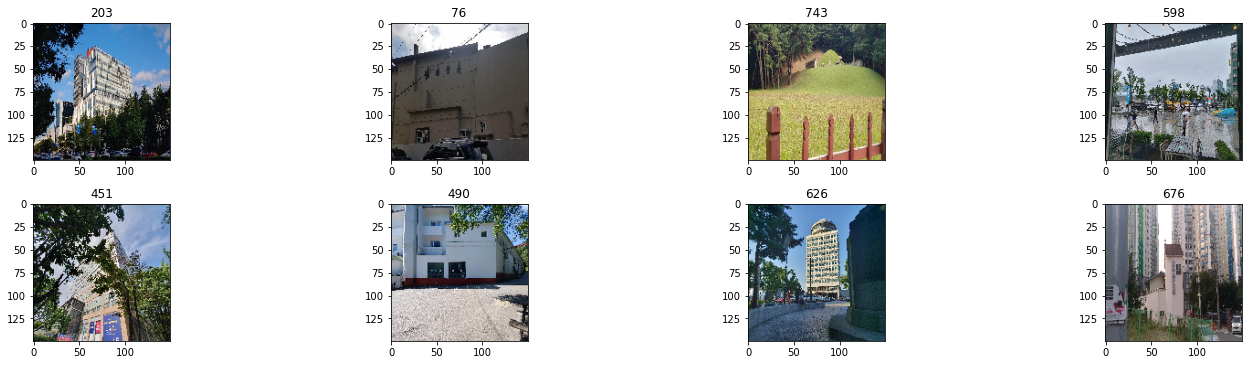

In [21]:
# 시각화 해보기
plt.figure(figsize=(20,20))
for i in range(0,8):
    plt.subplot(8,4,i+1)
    for xBatch, yBatch in train_generator:
        image = xBatch[0]
        plt.title(yBatch[0])
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## CNN

In [12]:

with tf.device('/device:GPU:0'):

    model = Sequential()

    model.add(Conv2D(filters=32,
                    kernel_size=(3,3),
                    activation='relu',
                    input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))    

    model.add(Conv2D(filters=64,
                    kernel_size=(3,3),
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=128,
                    kernel_size=(3,3),
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(units=512,
                   activation='relu'))

    model.add(Dense(units=1049,
                   activation='softmax'))

    print(model.summary())

    model.compile(optimizer=Adam(learning_rate=1e-4),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    history = model.fit(train_generator,
                        steps_per_epoch=len(train_df)/32, # batch_size * steps_per_epoch > data의 양 xxxxx
                        epochs=30,
                        validation_data=validation_generator,
                        validation_steps=len(valid_df)/32)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)      

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_1/conv2d_3/Relu (defined at <ipython-input-12-770efdbe1677>:41) ]] [Op:__inference_train_function_1213]

Function call stack:
train_function


## VGG16

In [12]:
from tensorflow.keras.applications import VGG16


model_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128,128,3))


model_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



with tf.device('/device:GPU:0'):

    ## Pretrained Network
    model_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(128,128,3))

    model_base.trainable = False  # Convolution Layer 동결

    model = Sequential()

    model.add(model_base)

    model.add(Flatten(input_shape=(4*4*512,)))

    model.add(Dense(256,
                    activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1049,
                    activation='softmax'))

    model.summary()

    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='/home/lab01/2nd Project/project_model/landmark_cnn.h5', monitor='val_acc', verbose=1, save_best_only=True)

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_accuracy', verbose=2, patience=5)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    history = model.fit(train_generator,
                        steps_per_epoch=len(train_df)/10, # batch_size * steps_per_epoch > data의 양 xxxxx
                        epochs=30,
                        callbacks=[checkpointer, early_stopping],
                        validation_data=validation_generator,
                        validation_steps=len(valid_df)/10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1049)              269593    
Total params: 17,081,689
Trainable params: 2,367,001
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/30


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_1/vgg16/block1_conv1/Relu (defined at <ipython-input-13-9478154bc5fc>:44) ]] [Op:__inference_train_function_2807]

Function call stack:
train_function


## mobile summary

In [10]:
from tensorflow.keras.applications import MobileNetV2

with tf.device('/device:GPU:1'):


    MobileNetV2_base = MobileNetV2(weights='imagenet',
                      include_top=False,
                      input_shape=(150,150,3))


    MobileNetV2_base.summary()



Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

## Mobile Net

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint




mobile_base = MobileNetV2(weights='imagenet',
                          include_top=False,
                          input_shape=(128,128,3))

mobile_base.trainable = True  # Convolution Layer 동결



model = Sequential()

model.add(mobile_base)

model.add(Flatten(input_shape=(5*5*1280,)))

model.add(Dense(256,
                activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1049,
                activation='softmax'))

model.summary()

# Model saving callback
checkpointer = ModelCheckpoint(filepath='./project_model/check_mobile.h5', monitor='val_loss', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=5)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=len(train_df)/10, # batch_size * steps_per_epoch > data의 양 xxxxx
                    epochs=30,
                    callbacks=[checkpointer, early_stopping],
                    validation_data=validation_generator,
                    validation_steps=len(valid_df)/10)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5243136   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1049)              269593    
Total params: 7,770,713
Trainable params: 7,736,601
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/30
7049/7048 [==============================] - ETA: 0s - loss: 5.8436 - sparse_categorical_accurac

## NASNetMobile

In [13]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


with tf.device('/device:GPU:0'):

    NASNetMobile_base = NASNetMobile(weights='imagenet',
                              include_top=False,
                              input_shape=(224,224,3))

    NASNetMobile_base.trainable = True  # Convolution Layer 동결



    model = Sequential()

    model.add(NASNetMobile_base)

    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(BatchNormalization())

    model.add(Dense(256,
                    activation='relu'))
    model.add(Dropout(0.5))

    model.add(BatchNormalization())


    model.add(Dense(1049,
                    activation='softmax'))

    model.summary()



    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='./project_model/check_NASNetMobile_base.h5', monitor='val_loss', verbose=1, save_best_only=True)

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=5)

    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    history = model.fit(train_generator,
                        steps_per_epoch=len(train_df)/5, # batch_size * steps_per_epoch > data의 양 xxxxx
                        epochs=30,
                        callbacks=[checkpointer, early_stopping],
                        validation_data=validation_generator,
                        validation_steps=len(valid_df)/5)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 7, 7, 1056)        4269716   
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 1056)        4224      
_________________________________________________________________
flatten (Flatten)            (None, 51744)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 51744)             206976    
_________________________________________________________________
dense (Dense)                (None, 256)               13246720  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1

KeyboardInterrupt: 

## Good Mobilenet

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



mobile_base = MobileNetV2(weights='imagenet',
                          include_top=False,
                          input_shape=(160,160,3))

mobile_base.trainable = True  # Convolution Layer 동결


def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

learning = tf.keras.callbacks.LearningRateScheduler(scheduler)


model = Sequential()

model.add(mobile_base)

model.add(BatchNormalization())

model.add(Flatten())

model.add(BatchNormalization())

model.add(Dense(256,
                activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())


model.add(Dense(1049,
                activation='softmax'))

model.summary()

# Model saving callback
checkpointer = ModelCheckpoint(filepath='./project_model/good_mobile_base.h5', monitor='val_loss', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=5)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=len(train_df)/10, # batch_size * steps_per_epoch > data의 양 xxxxx
                    epochs=30,
                    callbacks=[checkpointer, early_stopping, learning],
                    validation_data=validation_generator,
                    validation_steps=len(valid_df)/10)


In [23]:
# path = "./landmark
x_train = np.load("./x_train.npy")
y_train = np.load("./y_train.npy")
x_valid = np.load("./x_valid.npy")
y_valid = np.load("./y_valid.npy")

KeyboardInterrupt: 

In [14]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB2




def scheduler(epoch):
  if epoch < 5:
    return 0.001
  else:
    return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

learning = tf.keras.callbacks.LearningRateScheduler(scheduler)


EfficientNetB2_base = EfficientNetB2(weights='imagenet',
                          include_top=False,
                          input_shape=(128,128,3))

EfficientNetB2_base.trainable = True  # Convolution Layer 동결



model = Sequential()

model.add(EfficientNetB2_base)

model.add(BatchNormalization())

model.add(Flatten())

model.add(BatchNormalization())

model.add(Dense(256,
                activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())


model.add(Dense(1049,
                activation='softmax'))

model.summary()


# Model saving callback
checkpointer = ModelCheckpoint(filepath='./2nd Project/project_model/efn.EfficientNetB2_check.h5', monitor='val_loss', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=5)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=len(train_df)/10, # batch_size * steps_per_epoch > data의 양 xxxxx
                    epochs=30,
                    callbacks=[checkpointer, early_stopping, learning],
                    validation_data=(validation_generator),
                    validation_steps=len(valid_df)/10)

# history = model.fit(x_train,
#     y_train,
#     batch_size=128,
#     epochs=50,
#     validation_data=(x_valid, y_valid),
#     callbacks = callbacks,
# )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 4, 4, 1408)        7768569   
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 1408)        5632      
_________________________________________________________________
flatten_1 (Flatten)          (None, 22528)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 22528)             90112     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               5767424   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)              

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_1/efficientnetb2/stem_conv/Conv2D (defined at <ipython-input-14-9ff56c07b412>:62) ]] [Op:__inference_train_function_63759]

Function call stack:
train_function


In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import efficientnet
import efficientnet.tfkeras as efn 
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
# opt = tf.keras.optimizers.Adam(learning_rate = LR)


# def scheduler(epoch):
#   if epoch < 10:
#     return 0.0001
#   else:
#     return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

def get_lr_callback():
    lr_start   = 0.000001*10*0.5
    lr_max     = 0.0000005 * 5 * 10*0.5
    lr_min     = 0.000001 * 10*0.5
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
     
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max    
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
    return lr_callback

# learning = tf.keras.callbacks.LearningRateScheduler(get_lr_callback)



EfficientNetB2_base = efn.EfficientNetB2(weights='imagenet',
                          include_top=False,
                          input_shape=(160,160,3))

EfficientNetB2_base.trainable = True  # Convolution Layer 동결



model = Sequential()


model.add(EfficientNetB2_base)


model.add(GlobalAveragePooling2D())

model.add(Dense(1049,
                activation='softmax'))

model.summary()

# Model saving callback
checkpointer = ModelCheckpoint(filepath='/home/lab01/2nd Project/project_model/efficientnetb2.h5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                              save_weights_only=True)


# opt = tf.keras.optimizers.Adam(learning_rate = LR)


# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=5)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=len(train_df)/15, # batch_size * steps_per_epoch > data의 양 xxxxx
                    epochs=20,
                    callbacks=[checkpointer, early_stopping, get_lr_callback()],
                    validation_data=validation_generator,
                    validation_steps=len(valid_df)/15)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Functional) (None, 5, 5, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1049)              1478041   
Total params: 9,246,603
Trainable params: 9,179,035
Non-trainable params: 67,568
_________________________________________________________________
Epoch 1/20
4699/4698 [==============================] - ETA: 0s - loss: 6.9018 - sparse_categorical_accuracy: 0.0038
Epoch 00001: val_loss improved from inf to 6.75874, saving model to /home/lab01/2nd Project/project_model/efficientnetb2.h5
4699/4698 [==============================] - 1382s 294ms/step - loss: 6.9018 - sparse_categorical_accuracy: 0.0038 - val_loss: 6

In [23]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    train_path,
    x_col= "file",
    y_col= "label",
    target_size = (160,160),
    class_mode = "raw",
    batch_size = 32
)


Found 70481 validated image filenames.


In [24]:

validation_generator = validation_datagen.flow_from_dataframe(
    valid_df,
    train_path,
    x_col= "file",
    y_col= "label",
    target_size = (160,160),
    class_mode = "raw",
    batch_size = 32
)

Found 17621 validated image filenames.


In [25]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import efficientnet
import efficientnet.tfkeras as efn 
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
# opt = tf.keras.optimizers.Adam(learning_rate = LR)


# def scheduler(epoch):
#   if epoch < 10:
#     return 0.0001
#   else:
#     return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

with tf.device('/device:GPU:0'):


    def get_lr_callback():
        lr_start   = 0.000001*10*0.5
        lr_max     = 0.0000005 * 32 * 10*0.5
        lr_min     = 0.000001 * 10*0.5
        lr_ramp_ep = 5
        lr_sus_ep  = 0
        lr_decay   = 0.8


        def lrfn(epoch):
            if epoch < lr_ramp_ep:
                lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
            elif epoch < lr_ramp_ep + lr_sus_ep:
                lr = lr_max    
            else:
                lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
            return lr

        lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
        return lr_callback

    # learning = tf.keras.callbacks.LearningRateScheduler(get_lr_callback)



    EfficientNetB3_base = efn.EfficientNetB3(weights='imagenet',
                              include_top=False,
                              input_shape=(160,160,3))

    EfficientNetB3_base.trainable = False  # Convolution Layer 동결



    model = Sequential()


    model.add(EfficientNetB3_base)


    model.add(GlobalAveragePooling2D())

    model.add(Dense(1049,
                    activation='softmax'))

    model.summary()

    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='/home/lab01/2nd Project/project_model/efficientnetb3.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True)


    # opt = tf.keras.optimizers.Adam(learning_rate = LR)


    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=5)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    history = model.fit(train_generator,
                        steps_per_epoch=len(train_df)/32, # batch_size * steps_per_epoch > data의 양 xxxxx
                        epochs=10000,
                        callbacks=[checkpointer, early_stopping, get_lr_callback()],
                        validation_data=validation_generator,
                        validation_steps=len(valid_df)/32)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Functional) (None, 5, 5, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1049)              1612313   
Total params: 12,395,841
Trainable params: 1,612,313
Non-trainable params: 10,783,528
_________________________________________________________________
Epoch 1/10000
2203/2202 [==============================] - ETA: 0s - loss: 6.9429 - sparse_categorical_accuracy: 0.0028
Epoch 00001: val_loss improved from inf to 6.84143, saving model to /home/lab01/2nd Project/project_model/efficientnetb3.h5
2203/2202 [==============================] - 1022s 464ms/step - loss: 6.9429 - sparse_categorical_accuracy: 0.0028 - val

2203/2202 [==============================] - 1003s 455ms/step - loss: 1.3756 - sparse_categorical_accuracy: 0.7921 - val_loss: 1.4290 - val_sparse_categorical_accuracy: 0.7700
Epoch 19/10000
2203/2202 [==============================] - ETA: 0s - loss: 1.3564 - sparse_categorical_accuracy: 0.7933
Epoch 00019: val_loss improved from 1.42903 to 1.41458, saving model to /home/lab01/2nd Project/project_model/efficientnetb3.h5
2203/2202 [==============================] - 1004s 456ms/step - loss: 1.3564 - sparse_categorical_accuracy: 0.7933 - val_loss: 1.4146 - val_sparse_categorical_accuracy: 0.7721
Epoch 20/10000
2203/2202 [==============================] - ETA: 0s - loss: 1.3416 - sparse_categorical_accuracy: 0.7954
Epoch 00020: val_loss improved from 1.41458 to 1.40184, saving model to /home/lab01/2nd Project/project_model/efficientnetb3.h5
2203/2202 [==============================] - 1003s 455ms/step - loss: 1.3416 - sparse_categorical_accuracy: 0.7954 - val_loss: 1.4018 - val_sparse_cat

Epoch 38/10000
2203/2202 [==============================] - ETA: 0s - loss: 1.1793 - sparse_categorical_accuracy: 0.8175
Epoch 00038: val_loss improved from 1.27138 to 1.26550, saving model to /home/lab01/2nd Project/project_model/efficientnetb3.h5
2203/2202 [==============================] - 1007s 457ms/step - loss: 1.1793 - sparse_categorical_accuracy: 0.8175 - val_loss: 1.2655 - val_sparse_categorical_accuracy: 0.7889
Epoch 39/10000
2203/2202 [==============================] - ETA: 0s - loss: 1.1761 - sparse_categorical_accuracy: 0.8179
Epoch 00039: val_loss improved from 1.26550 to 1.25978, saving model to /home/lab01/2nd Project/project_model/efficientnetb3.h5
2203/2202 [==============================] - 1003s 455ms/step - loss: 1.1761 - sparse_categorical_accuracy: 0.8179 - val_loss: 1.2598 - val_sparse_categorical_accuracy: 0.7901
Epoch 40/10000
2203/2202 [==============================] - ETA: 0s - loss: 1.1672 - sparse_categorical_accuracy: 0.8194
Epoch 00040: val_loss improve

2203/2202 [==============================] - ETA: 0s - loss: 1.0618 - sparse_categorical_accuracy: 0.8354
Epoch 00057: val_loss improved from 1.17273 to 1.16802, saving model to /home/lab01/2nd Project/project_model/efficientnetb3.h5
2203/2202 [==============================] - 1014s 460ms/step - loss: 1.0618 - sparse_categorical_accuracy: 0.8354 - val_loss: 1.1680 - val_sparse_categorical_accuracy: 0.8020
Epoch 58/10000
2203/2202 [==============================] - ETA: 0s - loss: 1.0567 - sparse_categorical_accuracy: 0.8345
Epoch 00058: val_loss improved from 1.16802 to 1.16350, saving model to /home/lab01/2nd Project/project_model/efficientnetb3.h5
2203/2202 [==============================] - 1011s 459ms/step - loss: 1.0567 - sparse_categorical_accuracy: 0.8345 - val_loss: 1.1635 - val_sparse_categorical_accuracy: 0.8022
Epoch 59/10000
2203/2202 [==============================] - ETA: 0s - loss: 1.0528 - sparse_categorical_accuracy: 0.8344
Epoch 00059: val_loss improved from 1.16350 

2203/2202 [==============================] - 1011s 459ms/step - loss: 0.9710 - sparse_categorical_accuracy: 0.8466 - val_loss: 1.0896 - val_sparse_categorical_accuracy: 0.8124
Epoch 77/10000
2203/2202 [==============================] - ETA: 0s - loss: 0.9645 - sparse_categorical_accuracy: 0.8480
Epoch 00077: val_loss improved from 1.08962 to 1.08587, saving model to /home/lab01/2nd Project/project_model/efficientnetb3.h5
2203/2202 [==============================] - 1013s 460ms/step - loss: 0.9645 - sparse_categorical_accuracy: 0.8480 - val_loss: 1.0859 - val_sparse_categorical_accuracy: 0.8129
Epoch 78/10000
2203/2202 [==============================] - ETA: 0s - loss: 0.9580 - sparse_categorical_accuracy: 0.8487
Epoch 00078: val_loss improved from 1.08587 to 1.08220, saving model to /home/lab01/2nd Project/project_model/efficientnetb3.h5
2203/2202 [==============================] - 1016s 461ms/step - loss: 0.9580 - sparse_categorical_accuracy: 0.8487 - val_loss: 1.0822 - val_sparse_cat

KeyboardInterrupt: 

## incetion image generate 

In [10]:
from tensorflow.keras.applications import InceptionV3

with tf.device('/device:GPU:0'):


    InceptionV3_base = InceptionV3(weights='imagenet',
                      include_top=True,
                      input_shape=(150,150,3))


    InceptionV3_base.summary()



ValueError: When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (299, 299, 3).

In [24]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True
                                  )
validation_datagen =  ImageDataGenerator(rescale=1/255,
                                        vertical_flip=True)


train_generator = train_datagen.flow_from_dataframe(
    train_df,
    train_path,
    x_col= "file",
    y_col= "label",
    target_size = (299,299),
    class_mode = "raw",
    batch_size = 30
)


Found 70481 validated image filenames.


In [25]:


validation_generator = validation_datagen.flow_from_dataframe(
    valid_df,
    train_path,
    x_col= "file",
    y_col= "label",
    target_size = (299,299),
    class_mode = "raw",
    batch_size = 30
)

Found 17621 validated image filenames.


In [11]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf
from tensorflow import keras


with tf.device('/device:GPU:1'):

    def get_lr_callback():

        lr_start   = 0.000001*10*0.5
        lr_max     = 0.0000005 * 38 * 10*0.5
        lr_min     = 0.000001 * 10*0.5
        lr_ramp_ep = 5
        lr_sus_ep  = 0
        lr_decay   = 0.8


        def lrfn(epoch):
            if epoch < lr_ramp_ep:
                lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
            elif epoch < lr_ramp_ep + lr_sus_ep:
                lr = lr_max    
            else:
                lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
            return lr

        lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
        
        keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
        return lr_callback

    inception_base = InceptionV3(weights='imagenet',
                              include_top=False,
                              input_shape=(299,299,3))

    inception_base.trainable = True  # Convolution Layer 동결


    model = Sequential()


    model.add(inception_base)


    model.add(GlobalAveragePooling2D())

    model.add(Dense(1049,
                    activation='softmax'))

    model.summary()


    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='./project_model/Inception_generate2.h5', monitor='val_loss', verbose=1, save_best_only=True)

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=5)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    history = model.fit(train_generator,
                        steps_per_epoch=len(train_df)/38, # batch_size * steps_per_epoch > data의 양 xxxxx
                        epochs=100000,
                        callbacks=[checkpointer, early_stopping,get_lr_callback()],
                        validation_data=validation_generator,
                        validation_steps=len(valid_df)/38)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1049)              2149401   
Total params: 23,952,185
Trainable params: 23,917,753
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/100000
1855/1854 [==============================] - ETA: 0s - loss: 6.8147 - sparse_categorical_accuracy: 0.0180
Epoch 00001: val_loss improved from inf to 6.48081, saving model to ./project_model/Inception_generate2.h5
1855/1854 [==============================] - 2881s 2s/step - loss: 6.8147 - sparse_categorical_accuracy: 0.0180 - val_loss: 6.4808 - val_spar

Epoch 20/100000
1855/1854 [==============================] - ETA: 0s - loss: 0.0012 - sparse_categorical_accuracy: 0.9999
Epoch 00020: val_loss did not improve from 0.06762
1855/1854 [==============================] - 2917s 2s/step - loss: 0.0012 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.0696 - val_sparse_categorical_accuracy: 0.9838
Epoch 21/100000
1855/1854 [==============================] - ETA: 0s - loss: 0.0011 - sparse_categorical_accuracy: 0.9998
Epoch 00021: val_loss did not improve from 0.06762
1855/1854 [==============================] - 2920s 2s/step - loss: 0.0011 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0698 - val_sparse_categorical_accuracy: 0.9834
Epoch 00021: early stopping


In [26]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf
from tensorflow import keras


with tf.device('/device:GPU:1'):

    def get_lr_callback():

        lr_start   = 0.000001*10*0.5
        lr_max     = 0.0000005 * 30 * 10*0.5
        lr_min     = 0.000001 * 10*0.5
        lr_ramp_ep = 5
        lr_sus_ep  = 0
        lr_decay   = 0.8


        def lrfn(epoch):
            if epoch < lr_ramp_ep:
                lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
            elif epoch < lr_ramp_ep + lr_sus_ep:
                lr = lr_max    
            else:
                lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
            return lr

        lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
        
        keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
        return lr_callback

    inception_base = InceptionV3(weights='imagenet',
                              include_top=False,
                              input_shape=(299,299,3))

    inception_base.trainable = True  # Convolution Layer 동결


    model = load_model('./project_model/Inception_generate2.h5')



    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='./project_model/Inception_generate3.h5', monitor='val_loss', verbose=1, save_best_only=True)

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=5)

    model.compile(optimizer=Adam(learning_rate=1e-6),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    history = model.fit(train_generator,
                        steps_per_epoch=len(train_df)/30, # batch_size * steps_per_epoch > data의 양 xxxxx
                        epochs=100000,
                        callbacks=[checkpointer, early_stopping,get_lr_callback()],
                        validation_data=validation_generator,
                        validation_steps=len(valid_df)/30)


Epoch 1/100000
2350/2349 [==============================] - ETA: 0s - loss: 0.0025 - sparse_categorical_accuracy: 0.9997
Epoch 00001: val_loss improved from inf to 0.08807, saving model to ./project_model/Inception_generate3.h5
2350/2349 [==============================] - 2559s 1s/step - loss: 0.0025 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.0881 - val_sparse_categorical_accuracy: 0.9799
Epoch 2/100000
2350/2349 [==============================] - ETA: 0s - loss: 0.0044 - sparse_categorical_accuracy: 0.9994
Epoch 00002: val_loss did not improve from 0.08807
2350/2349 [==============================] - 2655s 1s/step - loss: 0.0044 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.0962 - val_sparse_categorical_accuracy: 0.9783
Epoch 3/100000
2350/2349 [==============================] - ETA: 0s - loss: 0.0108 - sparse_categorical_accuracy: 0.9980
Epoch 00003: val_loss did not improve from 0.08807
2350/2349 [==============================] - 2657s 1s/step - loss: 0.0108 - sparse

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf
from tensorflow import keras


with tf.device('/device:GPU:1'):

    def get_lr_callback():

        lr_start   = 0.000001*10*0.5
        lr_max     = 0.0000005 * 38 * 10*0.5
        lr_min     = 0.000001 * 10*0.5
        lr_ramp_ep = 5
        lr_sus_ep  = 0
        lr_decay   = 0.8


        def lrfn(epoch):
            if epoch < lr_ramp_ep:
                lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
            elif epoch < lr_ramp_ep + lr_sus_ep:
                lr = lr_max    
            else:
                lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
            return lr

        lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
        
        keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
        return lr_callback

    inception_base = InceptionV3(weights='imagenet',
                              include_top=False,
                              input_shape=(299,299,3))

    inception_base.trainable = True  # Convolution Layer 동결


    model = Sequential()


    model.add(inception_base)


    model.add(GlobalAveragePooling2D())

    model.add(Dense(1049,
                    activation='softmax'))

    model.summary()


    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='./project_model/Inception_generate2.h5', monitor='val_loss', verbose=1, save_best_only=True)

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=5)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    history = model.fit(train_generator,
                        steps_per_epoch=len(train_df)/38, # batch_size * steps_per_epoch > data의 양 xxxxx
                        epochs=100000,
                        callbacks=[checkpointer, early_stopping,get_lr_callback()],
                        validation_data=validation_generator,
                        validation_steps=len(valid_df)/38)


In [12]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import PReLU, Softmax



with tf.device('/device:GPU:1'):

    def get_lr_callback():

        lr_start   = 0.000001*10*0.5
        lr_max     = 0.0000005 * 38 * 10*0.5
        lr_min     = 0.000001 * 10*0.5
        lr_ramp_ep = 5
        lr_sus_ep  = 0
        lr_decay   = 0.8


        def lrfn(epoch):
            if epoch < lr_ramp_ep:
                lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
            elif epoch < lr_ramp_ep + lr_sus_ep:
                lr = lr_max    
            else:
                lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
            return lr

        lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
        
        keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
        return lr_callback

    inception_base = InceptionV3(weights='imagenet',
                              include_top=False,
                              input_shape=(299,299,3))

    inception_base.trainable = True  # Convolution Layer 동결



    model = load_model('./project_model/Inception_generate2.h5')

    model.add(Dropout(0.25))
    
    model.add(PReLU())
    
    model.add(Softmax(dtype='float32'))
    
    
    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='./project_model/Inception_generate2_add.h5', monitor='val_loss', verbose=1, save_best_only=True)

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=5)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    history = model.fit(train_generator,
                        steps_per_epoch=len(train_df)/38, # batch_size * steps_per_epoch > data의 양 xxxxx
                        epochs=100000,
                        callbacks=[checkpointer, early_stopping,get_lr_callback()],
                        validation_data=validation_generator,
                        validation_steps=len(valid_df)/38)


Epoch 1/100000
1855/1854 [==============================] - ETA: 0s - loss: 5.9590 - sparse_categorical_accuracy: 0.7498
Epoch 00001: val_loss improved from inf to 5.98324, saving model to ./project_model/Inception_generate2_add.h5
1855/1854 [==============================] - 2592s 1s/step - loss: 5.9590 - sparse_categorical_accuracy: 0.7498 - val_loss: 5.9832 - val_sparse_categorical_accuracy: 0.9802
Epoch 2/100000
1855/1854 [==============================] - ETA: 0s - loss: 5.9612 - sparse_categorical_accuracy: 0.7493
Epoch 00002: val_loss did not improve from 5.98324
1855/1854 [==============================] - 2588s 1s/step - loss: 5.9612 - sparse_categorical_accuracy: 0.7493 - val_loss: 5.9885 - val_sparse_categorical_accuracy: 0.9766
Epoch 3/100000
1855/1854 [==============================] - ETA: 0s - loss: 5.9616 - sparse_categorical_accuracy: 0.7507
Epoch 00003: val_loss did not improve from 5.98324
1855/1854 [==============================] - 2587s 1s/step - loss: 5.9616 - sp

In [19]:
from tensorflow.keras.layers import PReLU, Softmax
with tf.device('/device:GPU:1'):

    model = load_model('./project_model/Inception_generate2.h5')
    model.add(Dropout(0.4))
    model.add(PReLU())
    model.add(Softmax(dtype='float32'))
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1049)              2149401   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1049)              0         
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 1049)              1049      
_________________________________________________________________
softmax_1 (Softmax)          (None, 1049)              0         
Total params: 23,953,234
Trainable params: 23,918,802
Non-trainable params: 34,432
_______________________________________